# Imports

In [1]:
import h5py
import numpy as np
import os
import json
import labelme
import torch
import pickle

import torchvision.transforms as T
import torchvision.transforms.functional as F

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

torch.__version__

'1.0.1.post2'

In [2]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))
sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
from show import *
from dataset import *
from utils import *
from constants import *

# Loading images from json

In [4]:
img_dir = '{}/labels'.format(path_to_data)
img_paths = [os.path.join(img_dir, fname) for fname in sorted(os.listdir(img_dir))]
img_paths = [path for path in img_paths]

img_paths[:5]

['/data/labels/AD0008.json',
 '/data/labels/AD0012.json',
 '/data/labels/AD0021.json',
 '/data/labels/AD0024.json',
 '/data/labels/AD0025.json']

In [5]:
%timeit path_to_tuple(img_paths[0], label_name_to_value)

350 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(2048, 3072, 3) (2048, 3072, 1)


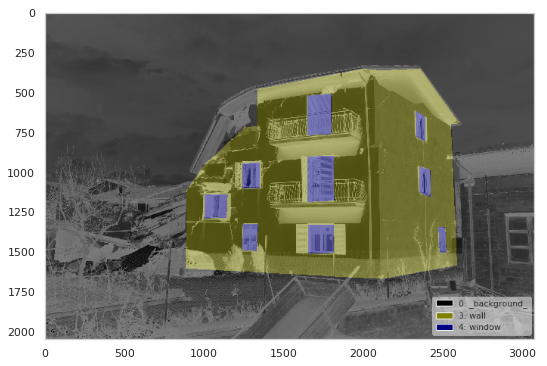

In [6]:
show_labeled_img(*path_to_tuple(img_paths[0], label_name_to_value), label_name_to_value)

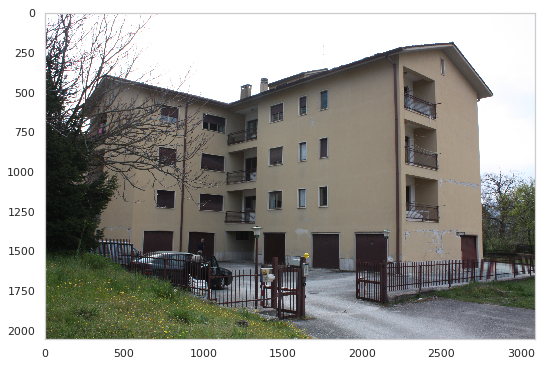

In [10]:
show_img(path_to_tuple(img_paths[416], label_name_to_value)[0])

# Handling of the image sizes for patches creation

In [9]:
from utils import *

In [10]:
shape_path = "{}/shapes{}.p".format(path_to_data, cropped_str)
def path_to_shape(p):
    _, lbl = path_to_tuple(p, label_name_to_value)
    if cropped:
        lbl = T.ToTensor()(lbl)
        up, down, left, right = find_limits(lbl, crop_margin)
        return down - up, right - left
    else:
        return lbl.shape

# too long to run again
if not os.path.exists(shape_path):
    shapes = [path_to_shape(p) for p in tqdm(img_paths)]
    pickle.dump(shapes, open(shape_path, "wb"))
else:
    shapes = pickle.load(open("{}/shapes{}.p".format(path_to_data, cropped_str), "rb"))
    
shapes[:5]

[(1446, 1870), (1946, 1770), (2047, 2271), (2048, 2271), (1446, 1070)]

In [11]:
better_shapes = [to_multiple_of_shape(s[0], s[1], patch_size, max_size) for s in shapes]

In [12]:
better_shapes[:5]

[(768, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 768)]

In [13]:
n_rows = [w//patch_size for h,w in better_shapes]
pickle.dump(n_rows, open(to_file_path('n_rows', 'p'), "wb"))

In [14]:
crops = [to_square_crops(s[0], s[1], patch_size) for s in better_shapes]
len(crops[0]), crops[0]

(12,
 [(0, 0),
  (0, 256),
  (0, 512),
  (0, 768),
  (256, 0),
  (256, 256),
  (256, 512),
  (256, 768),
  (512, 0),
  (512, 256),
  (512, 512),
  (512, 768)])

In [15]:
pickle.dump([len(c) for c in crops], open(to_file_path('crops', 'p'), "wb" ))

In [16]:
total_num_crops = len([a for b in crops for a in b])
total_num_crops

4776

In [17]:
to_multiple_of_shape(*(3072, 2048), patch_size, max_size)

(1024, 768)

In [18]:
def resize_and_crop(data, is_label=False):
    itp = 0 if is_label else 2 #0 is nearest, 2 is bilinear interpolation
    return T.Compose([
        T.ToPILImage(),
        T.Lambda(lambda img: T.Resize(to_multiple_of_shape(*img.size[::-1], patch_size, max_size), interpolation=itp)(img)),
        T.Lambda(lambda img: [F.crop(img, i, j, patch_size, patch_size) for (i, j) in to_square_crops(*img.size[::-1], patch_size)]),
        T.Lambda(lambda crops: (torch.stack([T.ToTensor()(crop) for crop in crops]) * 255).int()),
    ])(data)

In [19]:
def transform_data(img, lbl):
    tensorize = T.ToTensor()
    img, lbl = tensorize(img), tensorize(lbl)
    up, down, left, right = find_limits(lbl, crop_margin)
    lbl = resize_and_crop(lbl[:, up:down, left:right])
    img = resize_and_crop(img[:, up:down, left:right])
    return img, lbl

In [20]:
img_tmp, lbl_tmp = transform_data(*path_to_tuple(img_paths[0], label_name_to_value))
img_tmp.shape

torch.Size([12, 3, 256, 256])

In [21]:
img_grid = utils.make_grid(img_tmp, nrow=4, padding=10)
img_grid.shape

torch.Size([3, 808, 1074])

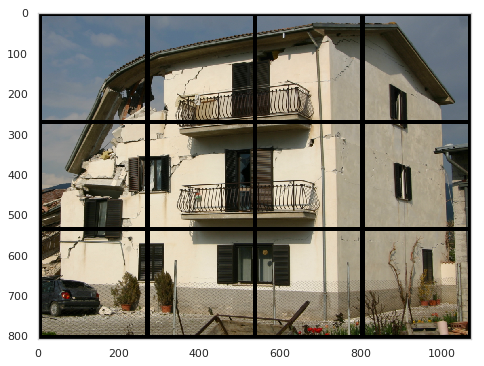

In [22]:
show_img(img_grid)

# Images from .json to .hdf5

In [23]:
img_shape = (3, patch_size, patch_size)
n_img = len(img_paths)

print(img_shape, n_img)

(3, 256, 256) 418


In [25]:
dset = FacadesDatasetH5Patches(to_file_path('images', 'hdf5'), normalized=True)

## Mean & Std

In [27]:
X_tr = torch.stack([data['image'] for data in tqdm(dset)])

mean_per_channel = X_tr.mean(dim=(0,2,3)).tolist()
std_per_channel = [(X_tr - X_tr.mean(dim=(0,2,3), keepdim=True))[:, c, :, :].std().item() for c in range(3)]

#pickle.dump(mean_per_channel, open(to_file_path('mean', 'p'), 'wb'))
#pickle.dump(std_per_channel, open(to_file_path('std', 'p'), 'wb'))

del X_tr

In [38]:
i = 5
img = dset[i]['image']
lbl = dset[i]['label']

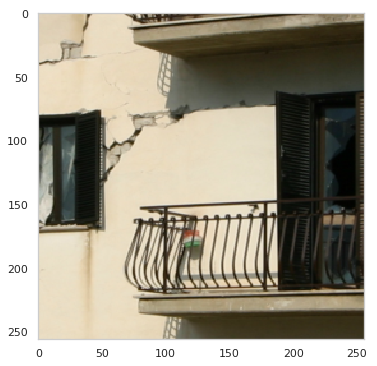

In [39]:
show_img(img)

(256, 256, 3) (256, 256, 1)


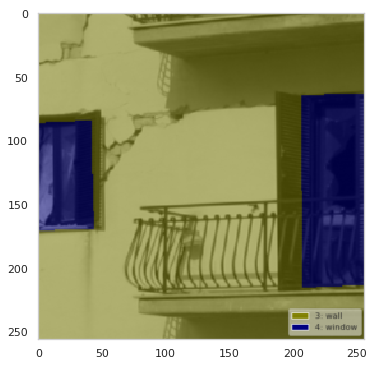

In [40]:
show_labeled_img(img, lbl, label_name_to_value)

In [41]:
%timeit [dset[i] for i in range(img_tmp.shape[0])]

28.2 ms ± 9.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
